# Policy-based method: REINFORCE

Now that we've implemented a value-based algorithm, it's only right that we should try out a policy-based one as well, right ? So let's learn about REINFORCE !

**Key facts**:
- It was first defined in ['Simple Statistical Gradient-Following Algorithms for Connectionist Reinforcement Learning' by Ronald J. WILLIAMS in 1992](https://link.springer.com/content/pdf/10.1007/BF00992696.pdf?pdf=button).
- It uses a **monte carlo** method

### Monte Carlo

As explained in the previous notebook, you can think of Monte Carlo as a method in which our agent learns after each episode instead of doing so at each time step like Temporal Difference.

This implies that there is no need to estimate the target: we can compute the episodic reward for each timestep using the memory batch:

![Monte Carlo formula](./assets/fig13.svg)

Let's begin by implementing this formula !


In [887]:
# Import necessary libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

from IPython.display import clear_output


# Set the learning rate and discount factor
lr = 1e-4
gamma = 0.995
eps = 1
# Set the number of episodes to run
episodes = 400


In [888]:
import gym

# Set the environment to use
env_name = 'CarRacing-v2'
# Create the environment
env = gym.make(env_name, render_mode="rgb_array", continuous=False)
env.reset()
print("ok")

ok


In [889]:
device = torch.device("cuda:0")
boost = 2
input_nbr = 12*12
output_nbr = 5
import time
# Define a neural network to model the policy
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()

        
        self.conv1 = torch.nn.Conv2d(1, 1, 5, padding=2) # Add a conv2d with a kernel size equal to 5
        self.maxpool1 = torch.nn.MaxPool2d(2, stride=2) # Add a MaxPool2d with kernel size and stride equal to 2
        self.conv2 = torch.nn.Conv2d(1, 1, 5, padding=2)# Add a conv2d with a kernel size equal to 5
        self.maxpool2 = torch.nn.MaxPool2d(2, stride=2) # Add a MaxPool2d with kernel size a
        self.conv3 = torch.nn.Conv2d(1, 1, 5, padding=2)# Add a conv2d with a kernel size equal to 5
        self.maxpool3 = torch.nn.MaxPool2d(2, stride=2) # Add a MaxPool2d with kernel size a
        
        # Create fully-connected layers with ReLU activations
        self.fc1 = torch.nn.Linear(input_nbr, 32*boost).to(device)
        self.fc2 = torch.nn.Linear(32*boost, 16*boost).to(device)
        self.fc3 = torch.nn.Linear(16*boost, output_nbr).to(device)
        self.softmax = torch.nn.Softmax(dim=0).to(device)

        self.actions, self.states, self.rewards = [], [], []
        
    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32).to(device)
        x = x.permute(2, 0, 1)
        x = torchvision.transforms.functional.rgb_to_grayscale(x)
        x = torch.nn.functional.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = torch.nn.functional.relu(self.conv3(x))
        x = self.maxpool3(x)
        
        x = x.reshape((-1,))
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)#x = torch.nn.functional.relu(self.fc3(x))
        #x = self.fc4(x)
        return self.softmax(x)

network = NeuralNetwork(env).to(device)

# Use Adam optimizer to optimize the neural network

optim = torch.optim.AdamW(network.parameters(), lr=lr)

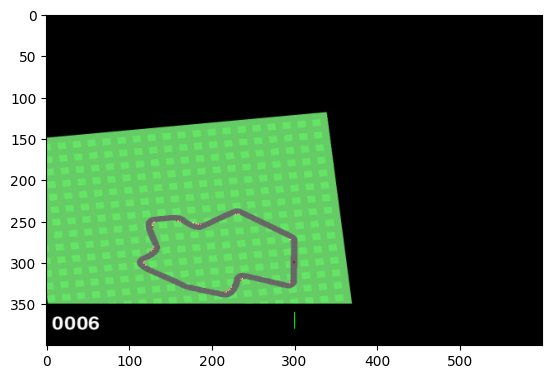

In [890]:
plt.imshow(env.render())

In [891]:
# Import the deque class from the collections module
from collections import deque

# Initialize empty lists for rewards and losses
recent_rewards = deque(maxlen=100)
train_rewards = []
train_loss = []

# We will avoid rendering our environment during training: 
# it would tremendously slow down the process
env = gym.make(env_name, continuous=False) 

In [892]:
from torch.distributions import Categorical

def policy_action(self, state):
    # Get the probabilities for each action, using the current state
    x = self.forward(state)
    # Create a distribution according to the probabilities
    m = Categorical(x)
    # Sample an action from the distribution
    action = m.sample()
    # Return the chosen action
    return action.item()

NeuralNetwork.policy_action = policy_action

In [893]:
def remember(self, Action, State, Reward):
    self.actions.append(Action)
    self.states.append(State)
    self.rewards.append(Reward)
    
NeuralNetwork.remember = remember

In [894]:
def discount_rewards(self):
    ## Discount the returns using the discount factor
    return np.cumsum(np.array(self.rewards[::-1])*gamma)[::-1]

NeuralNetwork.discount_rewards = discount_rewards

network.rewards = [0.2, 0.6, 0.1, 1.2, 0.9]
network.discount_rewards()

array([2.985 , 2.786 , 2.189 , 2.0895, 0.8955])

In [895]:
loss_list = []
def gradient_ascent(self, discounted_rewards):
    # Perform gradient ascent to update the probabilities in the distribution
    optim.zero_grad()
    global loss_list
    loss_list = []
    for State, Action, G in zip(self.states, self.actions, discounted_rewards):
        # Get the probabilities for the current state
        probs = network.forward(State)
        # Calculate the loss as the negative log probability of the chosen action
        # multiplied by the discounted return
        loss = G * (-Categorical(probs).log_prob(torch.tensor(Action).to(device)))
        loss_list.append(round(loss.item(), 5))
        # Clear the gradients, backpropagate the loss, and update the network parameters
        loss.backward()
    optim.step()

NeuralNetwork.gradient_ascent = gradient_ascent

In [896]:
# Iterate over the number of episodes
import time

for episode in range(500):#episodes):
    # Reset the environment and initialize empty lists for actions, states, and rewards
    state, _  = env.reset()
    network.actions, network.states, network.rewards = [], [], []

    # Train the agent for a single episode
    action_dict = {0:0, 1:0, 2:0, 3:0, 4:0}
    action_rand_dict = {0:0, 1:0, 2:0, 3:0, 4:0}
    for i in range(80+episode):
        action = 0#3 if episode % 5 == 0 else 0
        if i > 35:
            p = np.random.random()
            if p > eps:
                action = network.policy_action(state)
                action_dict[action] += 1
                #print('n', end='')
            else:
                action = np.random.choice(5)
                action_rand_dict[action] += 1
                #print('r', end='')
            eps = max(eps*0.9995, 0.01)

        # Take the action in the environment and get the new state, reward, and done flag
        new_state, reward, termination, truncation, _ = env.step(action)
        reward += 0.1
        
        # Save the action, state, and reward for later
        network.remember(action, state, reward)
        state = new_state

        # If the episode is done or the time limit is reached, stop training
        if termination or truncation:
            break
    # Perform gradient ascent
    network.gradient_ascent(network.discount_rewards())

    # Save the total reward for the episode and append it to the recent rewards queue
    train_rewards.append(np.sum(network.rewards))
    recent_rewards.append(train_rewards[-1])
    # Print the mean recent reward every 50 episodes
    if True:#episode % 10 == 0:
        clear_output(wait=True)
        print(f"E:{episode} R:{np.mean(recent_rewards):>6.3f}", end=" | ")
        print(list(action_dict.values()), list(action_rand_dict.values()))
        print(loss_list)

    if np.mean(recent_rewards) > 400:
        break

E:499 R:60.667 | [504, 9, 7, 17, 1] [1, 1, 2, 0, 1]
[0.07228, 0.01376, 0.06537, 0.07267, 0.11996, 0.12937, 0.08177, 0.11202, 0.13073, 0.16061, 0.16811, 0.39298, 0.43396, 0.38037, 0.3613, 0.4882, 0.4552, 0.65712, 0.52861, 1.04432, 0.67888, 0.98349, 0.96555, 1.07448, 1.54707, 1.79345, 2.25652, 2.44398, 2.4362, 2.44702, 2.64672, 2.57038, 2.39716, 2.44553, 2.71118, 2.80347, 2.72699, 2.76929, 2.8044, 2.87735, 3.10554, 3.00358, 3.23202, 4.03955, 5.03364, 5.20462, 5.03941, 5.04114, 5.77985, 6.07678, 6.07678, 6.07678, 6.07678, 6.07678, 6.07678, 6.07678, 277.80414, 5.39431, 6.15336, 6.1645, 6.15336, 6.16506, 6.17464, 6.13542, 6.13761, 6.13878, 6.32998, 6.32998, 6.32998, 6.32998, 6.32998, 6.32998, 6.32998, 6.32998, 6.32998, 6.32998, 6.32998, 6.32998, 6.32998, 6.32998, 6.32998, 6.32998, 6.32998, 269.18628, 4.63929, 6.3402, 6.59952, 6.60113, 6.62378, 6.63703, 6.59906, 6.60503, 6.59329, 6.59972, 6.59329, 6.59329, 5.75269, 5.75269, 5.75269, 235.24127, 5.76787, 5.78619, 233.90912, 5.84504, 5.86128, 5

0.0000100


/tmp/ipykernel_11484/2048869610.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


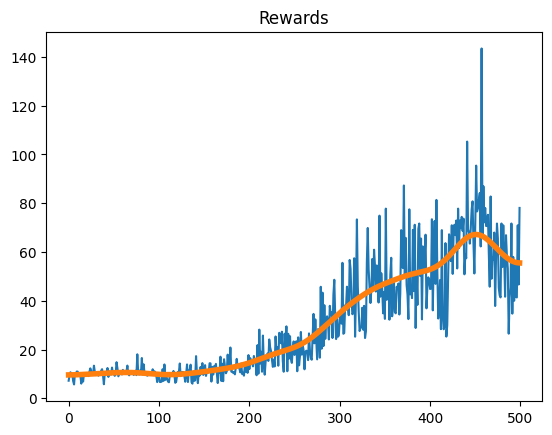

In [897]:
fig, ax = plt.subplots()

ax.plot(train_rewards)
ax.plot(gaussian_filter1d(train_rewards, sigma=20), linewidth=4)
ax.set_title('Rewards')

fig.show()
print(f"{1/10**5:.7f}")

Finally, let's display five episodes of our trained agent to see how glorious it is:

In [ ]:
env = gym.make(env_name, render_mode="human", continuous=False)

for _ in range(5):
    Rewards = []
    
    state, _ = env.reset()
    done = False
    
    for _ in range(1000):
        # Calculate the probabilities of taking each action using the trained
        # neural network
        probs = network.forward(state)
        
        # Sample an action from the resulting distribution using the 
        # torch.distributions.Categorical() method
        action = int(torch.distributions.Categorical(probs).sample())

        new_state, reward, termination, truncation, _ = env.step(action)
    
        state = new_state

        Rewards.append(reward)

        if termination or truncation:
            break
    
    # Print the total rewards for the current episode
    print(f'Reward: {sum(Rewards)}')

# Close the environment
env.close()

Reward: -32.692307692308056
Reward: -27.797833935018172
Reward: -42.85714285714334
Reward: 7.936507936508127
